In [17]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [18]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score, time_to_next = dict_to_frequency_list(dic)
print(score)

[[262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [294], [440], [587], [698], [440], [587], [698], [262], [294], [440], [587], [698], [440], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [247], [294], [392], [587], [698], [392], [587], [698], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [392], [523], [659], [392], [523], [659], [262], [330], [440], [659], [880], [440], [659], [880], [262], [330], [440], [659], [880], [440], [659], [880], [262], [294], [370], [440], [587], [370], [440], [587], [262], [294], [370], [440], [587], [370], [440], [587], [247], [294], [392], [587], [784], [392], [587], [784], [247], [294], [392], [587], [784], [392], [587], [784], [247], [262], [330], [392], [523], [330], [392], [523], [247], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392], [523], [220], [262], [330], [392], [523], [330], [392]

In [19]:
# Create cov_dict

cov_dict = {}
sample_length = 1000
sample_rate = 44100
M=9
T=0.465
v=2.37
sigma_f=5
sigma_n=0.1
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)

for state in score[:20]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=T, v=v) + sigma_n**2 * np.eye(sample_length)

In [20]:
# Create state transmission matrix, T. Here we are using uniform distribution as all notes are the same length

# For now we will go with a very simple uniform distribution to the current or next state
K = len(score[:40]) # The number of states, K
T = np.full((K, K), -np.inf) 
for i in range(K-1): # Populate transition probabilities except final row
    T[i][i], T[i][i+1] = np.log(0.5), np.log(0.5)
T[-1][-1] = np.log(1) # Update final row so transition probability is one, to itself



In [21]:
print(T)

[[-0.69314718 -0.69314718        -inf ...        -inf        -inf
         -inf]
 [       -inf -0.69314718 -0.69314718 ...        -inf        -inf
         -inf]
 [       -inf        -inf -0.69314718 ...        -inf        -inf
         -inf]
 ...
 [       -inf        -inf        -inf ... -0.69314718 -0.69314718
         -inf]
 [       -inf        -inf        -inf ...        -inf -0.69314718
  -0.69314718]
 [       -inf        -inf        -inf ...        -inf        -inf
   0.        ]]


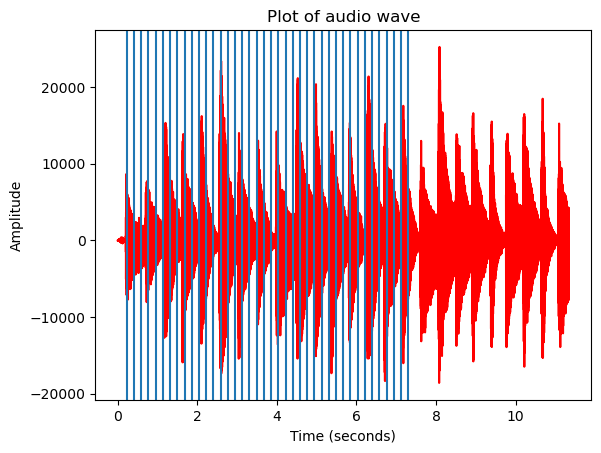

In [22]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 8000
sample_length = 1000
show = 500000
offset = 10000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [23]:
for k in range(0,5):
    print(k)

0
1
2
3
4


In [24]:
def viterbi(y: List[np.ndarray], T: np.ndarray, states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = T.shape[0] # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    max_s = 0
    path = []
    w = 10
    chunk = 0
    step = w //4
    
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    gamma[0,0] = 1 * lml # Initialise probability of first audio sample with state 1

    # Iterate through observations
    for i in range(1, n):
        k0_index = chunk * step
        for k in range(k0_index, k0_index + w):

            lml = -helper.stable_nlml(time_samples, y[i], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
            same_state = lml + gamma[k,i-1] + T[k, k]
            advance_state = lml + gamma[k-1, i-1] + T[k-1, k]

            if same_state >= advance_state:
                gamma[k, i] = same_state
                delta[k, i] = k
            else:
                gamma[k, i] = advance_state
                delta[k, i] = k - 1

        max_s = np.argmax(gamma[:,i])
        print(max_s, flush=True)
        path.append(max_s)
        if max_s >= k0_index + w - step:
            chunk += 1
            print('new chunk!: ', chunk)
    
    # Build the optimal path, for comparison to live output
    optimal_path = np.zeros(n, 'B')
    optimal_path[-1] = np.argmax(gamma[:, n-1])

    for i in reversed(range(1, n)):
        optimal_path[i-1] = delta[optimal_path[i], i]

    return path, optimal_path


path, optimal = viterbi(audio_data[:60], T, score[:60], cov_dict=cov_dict )
print(path, optimal)

    

0
0
1
1
1
2
2
3
3
3
4
4
5
5
5
6
6
7
7
7
8
new chunk!:  1
8
8
9
9
10
new chunk!:  2
10
10
11
11
12
new chunk!:  3
12
12
13
13
14
new chunk!:  4
14
14
15
15
16
new chunk!:  5
16
16
17
17
18
new chunk!:  6
18
19
19
19
19
19
21
new chunk!:  7
21
22
new chunk!:  8
22
22
22
22
[0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18, 19, 19, 19, 19, 19, 21, 21, 22, 22, 22, 22, 22] [ 0  0  0  1  1  1  2  2  3  3  3  4  4  5  5  5  6  6  7  7  7  8  8  8
  9  9 10 10 10 11 11 12 12 12 13 13 14 14 14 15 15 16 16 16 17 17 18 18
 19 19 19 19 20 21 21 22 22 22 22 22]


In [25]:
print(optimal)

[ 0  0  0  1  1  1  2  2  3  3  3  4  4  5  5  5  6  6  7  7  7  8  8  8
  9  9 10 10 10 11 11 12 12 12 13 13 14 14 14 15 15 16 16 16 17 17 18 18
 19 19 19 19 20 21 21 22 22 22 22 22]


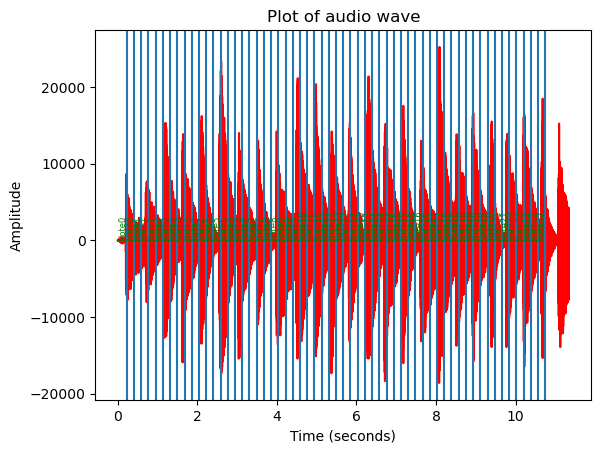

In [27]:
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for _, i in enumerate(sample_indices[:59]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 0.3, f'Note{optimal[_]}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    